In [1]:
#### 利益改善され、割安な銘柄が動意づいたときに検知することを目的とする

In [2]:
# 読み込みファイルパスの設定とimportしたいmoduleパス(pythonパス)の設定
from pathlib import Path
import os, sys

CURRENT_DIR = Path(os.getcwd())
PJ_DIR = CURRENT_DIR.parent.parent
LIB_DIR = PJ_DIR / "lib"
DATA_DIR = PJ_DIR / "data" 

sys.path.append(str(LIB_DIR))

# notebook内で利用するmoduleのimport
from lib_dataprocess import KessanPl, PricelistFig, PricelistPl, MeigaralistPl, read_data
from lib_dataprocess import ShikihoPl, FinancequotePl, print_finance_quote, PricelistFig
import polars as pl
from datetime import date
from dateutil.relativedelta import relativedelta

fp = DATA_DIR/"reviced_pricelist.parquet"
df = read_data(fp)
RevPl = PricelistPl(df)

# dataの読み込み
fp = DATA_DIR/"raw_pricelist.parquet"
df = read_data(fp)
PPL = PricelistPl(df)

fp = DATA_DIR/"finance_quote.parquet"
df = read_data(fp)
FPL = FinancequotePl(df)
FPL.with_columns_market_cap()

fp = DATA_DIR/"meigaralist.parquet"
df = read_data(fp)
MPL = MeigaralistPl(df)

fp = DATA_DIR/"shikiho.parquet"
df = read_data(fp)
SPL = ShikihoPl(df)


In [3]:
#####
##### KessanPl.dfの加工
#####

In [4]:
#パラメータのセット
# 決算日の指定 -> 指定した日の四半期決算でランキングを作成する
valuation_date = date.today()
valuation_date = date(2024, 9, 26)
# 売上高伸び率を何%以上にするか
min_sales_growthrate = 10

In [5]:
# 読み込みと加工
# 読み込み
fp = DATA_DIR/"kessan.parquet"
df = read_data(fp)
KPL1 = KessanPl(df)
KPL2 = KessanPl(df)

# データ加工
KPL1.with_columns_growthrate_lastyear()
KPL2.with_columns_diff_growthrate()
KPL1.df = KPL1.df.filter(pl.col("settlement_type")=="四")
KPL2.df = KPL2.df.filter(pl.col("settlement_type")=="四")
df = KPL1.df.join(KPL2.df, on=["code", "settlement_date"], how="left")
df = df.select([
    "code", "settlement_date", "announcement_date", "sales", "operating_income", "sales_growthrate", "diff_operating_income_growthrate"
])
# valuation_date日時点の最新データに絞る
df = df.filter(pl.col("announcement_date")<=valuation_date)
df = df.group_by("code").agg([
    pl.col("settlement_date").last().alias("settlement_date"),
    pl.col("announcement_date").last().alias("announcement_date"),
    pl.col("sales").last().alias("sales"),
    pl.col("operating_income").last().alias("operating_income"),
    pl.col("sales_growthrate").last().alias("sales_growthrate"),
    pl.col("diff_operating_income_growthrate").last().alias("diff_operating_income_growthrate")
])

target_date = valuation_date - relativedelta(days=90)
df = df.filter(pl.col("announcement_date")>target_date)

cpl_df = df
cpl_df

code,settlement_date,announcement_date,sales,operating_income,sales_growthrate,diff_operating_income_growthrate
i64,date,date,i64,i64,f64,f64
1301,2024-06-30,2024-08-05,68204,3102,9.4,11.7
1332,2024-06-30,2024-08-06,220644,9724,10.4,0.0
1333,2024-06-30,2024-08-05,256928,7657,2.4,-0.5
1375,2024-06-30,2024-08-08,10172,-77,22.9,12.5
1376,2024-05-31,2024-07-10,23224,1150,1.9,-16.0
…,…,…,…,…,…,…
9991,2024-06-30,2024-07-25,26954,1366,-14.5,-2.5
9993,2024-05-31,2024-07-11,24969,-408,1.8,-108.5
9994,2024-06-30,2024-08-09,39151,1286,0.6,-14.9


In [6]:
##### 
##### reviced_pricelistの加工
#####

In [7]:
#パラメータのセット
min_zs25 = 2
min_daily_updown_rate = 2
min_overnight_updown_rate = 0

In [8]:
# 読み込みと加工
# 読み込み
fp = DATA_DIR/"reviced_pricelist.parquet"
df = read_data(fp)
RPL = PricelistPl(df)

# データ加工
# rpl_dfに評価列を追加
RPL.with_columns_moving_zscore()
RPL.with_columns_daily_updown_rate()
RPL.with_columns_overnight_updown("yesterday")
rpl_df = RPL.df
# rpl_dfの評価対象行を抽出
ori_cols = rpl_df.columns
df = cpl_df
df = df.select(["code", "announcement_date"])
df = df.with_columns([
    pl.col("announcement_date").alias("start_date"),
    (pl.col("announcement_date") + pl.duration(days=93)).alias("end_date")
])
df = df.select(["code", "start_date", "end_date"])
df = rpl_df.join(df, on="code", how="left")
df = df.filter(pl.col("date")>=pl.col("start_date"))\
    .filter(pl.col("date")<=pl.col("end_date"))
df = df.select(ori_cols)
rpl_df = df
rpl_df

code,date,open,high,low,close,volume,accumulated_split_rate,zs25,daily_updown_rate,overnight_updown_rate
i64,date,f64,f64,f64,f64,f64,f64,f64,f64,f64
1301,2024-08-05,3610.0,3780.0,3400.0,3450.0,105000.0,1.0,4.2,-4.43,-3.99
1301,2024-08-06,3855.0,3855.0,3605.0,3665.0,50100.0,1.0,1.2,-4.93,11.74
1301,2024-08-07,3630.0,3755.0,3600.0,3650.0,38600.0,1.0,0.58,0.55,-0.95
1301,2024-08-08,3635.0,3690.0,3630.0,3645.0,23400.0,1.0,-0.23,0.28,-0.41
1301,2024-08-09,3690.0,3720.0,3630.0,3675.0,31700.0,1.0,0.17,-0.41,1.23
…,…,…,…,…,…,…,…,…,…,…
9997,2024-10-28,702.0,711.0,699.0,708.0,154300.0,1.0,-0.59,0.85,0.86
9997,2024-10-29,711.0,722.0,710.0,716.0,205600.0,1.0,-0.39,0.7,0.42
9997,2024-10-30,715.0,718.0,711.0,712.0,208800.0,1.0,-0.33,-0.42,-0.14


In [9]:
##### 
##### cpl_dfとrpl_dfを連結して、screening用のdfを作成
#####

In [10]:
df = rpl_df.join(cpl_df, on="code", how="left")
screened_df = df
screened_df

code,date,open,high,low,close,volume,accumulated_split_rate,zs25,daily_updown_rate,overnight_updown_rate,settlement_date,announcement_date,sales,operating_income,sales_growthrate,diff_operating_income_growthrate
i64,date,f64,f64,f64,f64,f64,f64,f64,f64,f64,date,date,i64,i64,f64,f64
1301,2024-08-05,3610.0,3780.0,3400.0,3450.0,105000.0,1.0,4.2,-4.43,-3.99,2024-06-30,2024-08-05,68204,3102,9.4,11.7
1301,2024-08-06,3855.0,3855.0,3605.0,3665.0,50100.0,1.0,1.2,-4.93,11.74,2024-06-30,2024-08-05,68204,3102,9.4,11.7
1301,2024-08-07,3630.0,3755.0,3600.0,3650.0,38600.0,1.0,0.58,0.55,-0.95,2024-06-30,2024-08-05,68204,3102,9.4,11.7
1301,2024-08-08,3635.0,3690.0,3630.0,3645.0,23400.0,1.0,-0.23,0.28,-0.41,2024-06-30,2024-08-05,68204,3102,9.4,11.7
1301,2024-08-09,3690.0,3720.0,3630.0,3675.0,31700.0,1.0,0.17,-0.41,1.23,2024-06-30,2024-08-05,68204,3102,9.4,11.7
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
9997,2024-10-28,702.0,711.0,699.0,708.0,154300.0,1.0,-0.59,0.85,0.86,2024-06-30,2024-07-31,51368,982,-0.9,36.7
9997,2024-10-29,711.0,722.0,710.0,716.0,205600.0,1.0,-0.39,0.7,0.42,2024-06-30,2024-07-31,51368,982,-0.9,36.7
9997,2024-10-30,715.0,718.0,711.0,712.0,208800.0,1.0,-0.33,-0.42,-0.14,2024-06-30,2024-07-31,51368,982,-0.9,36.7


In [11]:
##### 
##### screening
#####

In [12]:
# para
min_zs25 = 3
min_daily_updown_rate = 2
min_overnight_updown_rate = 0
min_sales_growthrate = 10
min_sgr_dogr_ratio = 2

In [67]:
df = screened_df

df = df.filter([
    pl.col("zs25")>=min_zs25,
    pl.col("daily_updown_rate")>=min_daily_updown_rate,
    pl.col("overnight_updown_rate")>=min_overnight_updown_rate,
    pl.col("sales_growthrate")>=min_sales_growthrate,
    pl.lit(min_sgr_dogr_ratio) * pl.col("sales_growthrate")<pl.col("diff_operating_income_growthrate")
])
df[20:30]

code,date,open,high,low,close,volume,accumulated_split_rate,zs25,daily_updown_rate,overnight_updown_rate,settlement_date,announcement_date,sales,operating_income,sales_growthrate,diff_operating_income_growthrate
i64,date,f64,f64,f64,f64,f64,f64,f64,f64,f64,date,date,i64,i64,f64,f64
3708,2024-09-26,3785.0,3880.0,3775.0,3865.0,44800.0,1.0,4.04,2.11,0.53,2024-06-30,2024-08-14,22702,1049,10.4,38.1
3727,2024-10-09,182.0,189.0,175.0,189.0,5.6819e6,1.0,4.74,3.85,30.94,2024-06-30,2024-08-13,1037,84,12.5,42.6
3763,2024-10-07,1599.0,1677.0,1591.0,1667.0,102700.0,1.0,4.4,4.25,0.95,2024-06-30,2024-08-09,1485,193,14.6,89.9
3773,2024-10-21,1120.0,1179.0,1108.0,1160.0,363200.0,1.0,4.57,3.57,3.9,2024-06-30,2024-08-07,1482,265,20.6,51.0
3837,2024-11-08,1878.0,1937.0,1876.0,1922.0,53700.0,1.0,3.94,2.34,0.75,2024-06-30,2024-08-07,3753,456,10.5,33.0
3920,2024-09-12,563.0,649.0,557.0,593.0,366800.0,1.0,4.63,5.33,1.81,2024-06-30,2024-08-09,576,147,25.2,64.7
3922,2024-07-11,1820.0,1871.0,1802.0,1871.0,50200.0,1.0,3.61,2.8,0.22,2024-05-31,2024-07-11,1925,484,19.7,44.5
3922,2024-07-12,1959.0,2116.0,1956.0,2081.0,267300.0,1.0,4.73,6.23,4.7,2024-05-31,2024-07-11,1925,484,19.7,44.5
3930,2024-12-13,931.0,1074.0,906.0,1000.0,257300.0,1.0,4.8,7.41,0.76,2024-07-31,2024-09-13,931,107,14.8,63.3


In [68]:
##### 
##### individual stock info
#####

In [71]:
# set code
code = 3708
marked_day = date(2024, 9, 26)

In [72]:
### 最新情報
# 指定したcodeの指定した日における株価と各種ファンダメンタルズデータをまとめて標準出力する
# pricelist_dfは、raw_pricelistかreviced_pricelistかケースに応じて使い分ける。
# def print_finance_quote(
#        pricelist_df: pl.DataFrame,
#        finance_quote_df: pl.DataFrame,
#        code: int, 
#        valuation_date: date=date.today()
#    ) -> None:
print_finance_quote(PPL.df, FPL.df, code, valuation_date=marked_day)
print()
SPL.print_stock_df(code, num=4, valuation_date=valuation_date)

特種東海製紙(3708)の銘柄情報

終値: 3865.0円(2024年09月26日)
予想配当利回り: 3.1%(2024年09月26日)
予想PER: 10.6倍(2024年09月26日)
実績PBR: 0.59倍(2024年09月26日)
自己資本比率: 57.8%(2024年09月26日)
予想ROE: 5.53%(2024年09月26日)
予想ROA: 3.2%(2024年09月26日)
時価総額: 502.4億円(2024年09月26日)

3708(特種東海製紙)の四季報データ履歴

発行日: 2024年09月13日
【上振れ】
  前期連結の資源再活用会社がフル寄与。特殊紙と生活紙は前期の価格改定が通期寄与で伸長。岐阜工場閉鎖で労務費削減も効く。原燃料高や償却費増こなし、営業利益上振れ公算。段ボール需要減で産業素材関連の持分益は減少。増配余地。
【新設】
  産業素材の島田工場の廃棄物ボイラー(投資125億円)は27年1月稼働。24年10月特殊紙全商品を10%以上値上げ。

発行日: 2024年06月14日
【続伸】
  前期連結の資源再活用会社がフル寄与。家庭紙や産業素材堅調。特殊紙も回復に向かう。償却費増や資材価格高騰あるが、岐阜工場閉鎖で労務費削減もあり、営業益続伸。産業素材関連の持分益は減少。
【Ｍ＆Ａ】
  廃棄物収集エリア拡大狙い、西東京拠点の廃棄物処理会社を4月子会社化。金属や複合素材を含む難易度高いプラスチックのリサイクル技術確立目指す。

発行日: 2024年03月16日
【続伸】
  家庭紙や産業素材は値上げ浸透し伸長。が、数量減の特殊紙は想定より苦戦。営業増益幅縮小。持分益拡大。25年3月期は前期連結の資源再活用の子会社フル寄与。家庭紙や産業素材も堅調。特殊紙も上向く。償却費増など吸収し営業益続伸。
【脱炭素】
  4月小売電気事業を非化石燃料子会社に移管、製造業の脱炭素支援へ。島田工場バイオマスボイラーは27年1月稼働。

発行日: 2023年12月15日
【反発】
  家庭紙は数量減だが値上げ浸透し拡大。資源再活用では連結子会社が上乗せで伸長。ただ特殊紙は数量減響き上期不冴え、下期値上げ浸透でも営業増益幅は前号比縮小。持分益は想定超で純益増。25年3月期は家庭紙堅調で特殊紙も持ち直す。
【集約】
  ファンシーペーパーの生産

2024-09-26


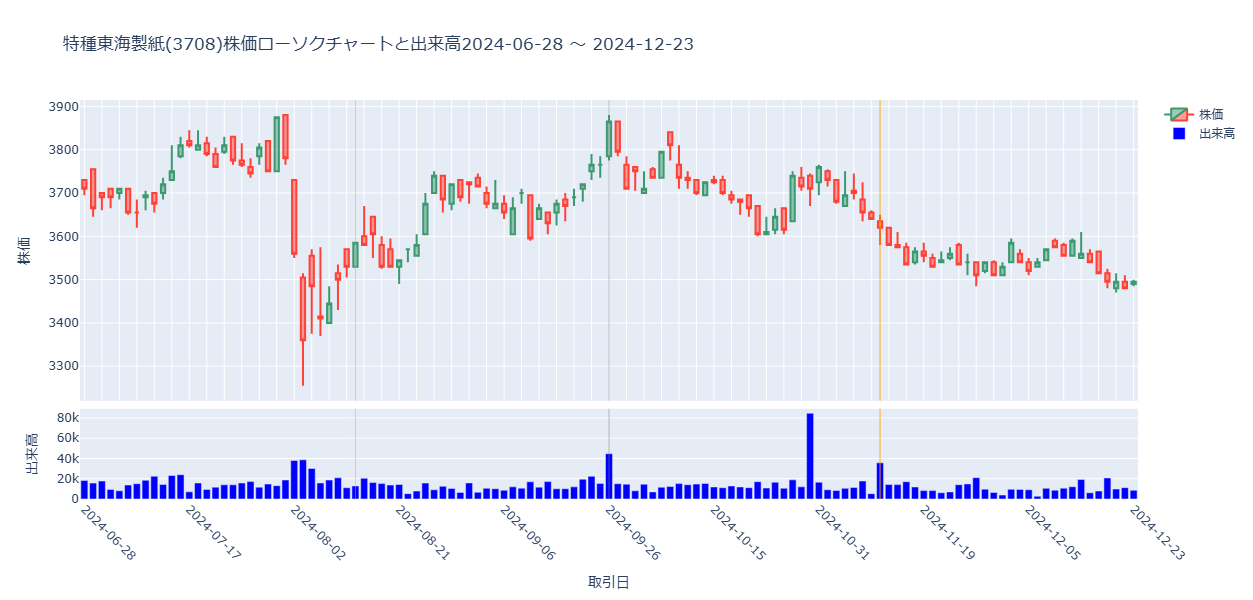

In [73]:
print(valuation_date)
delta = relativedelta(days=90)
start_date = marked_day - delta
end_date = marked_day + delta
PFIG = PricelistFig(code, RevPl.df, MPL.df, start_date, end_date)
df = RevPl.df.filter(pl.col("code")==code).filter(pl.col("date")<=marked_day)
vline_date = df["date"].to_list()[-1]
# screeningで抽出した日にvlineを引く 
PFIG.add_vline(marked_day)
# 決算発表日にvlineを引く
PFIG.add_vline_announcement_date()
PFIG.fig.show()